# Exercise 2.6

## ToDo

* README.md
* requirements.txt
* move helper function to .py file

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mlb as mlb

### General setup

In [2]:
rng = np.random.default_rng(3317)
plt.style.use("ggplot")

In [3]:
# def kl(p_hat, p):
#     p_hat = np.clip(p_hat, 1e-12, 1 - 1e-12)
#     p = np.clip(p, 1e-12, 1 - 1e-12)
#     return p_hat * np.log(p_hat / p) + (1 - p_hat) * np.log((1 - p_hat) / (1 - p))


In [4]:
# def kl_upper_bound(p_hat, n, delta, tol=1e-12, max_iter=60):
#     eps = np.log(1.0 / delta) / n
#     if p_hat <= 0.0:
#         return 1.0 - np.exp(-eps)
#     if p_hat >= 1.0:
#         return 1.0
#     lo, hi = p_hat, 1.0
#     for _ in range(max_iter):
#         mid = 0.5 * (lo + hi)
#         if mlb.kl(p_hat, mid) > eps:
#             hi = mid
#         else:
#             lo = mid
#         if hi - lo < tol:
#             break
#     return hi


## Parameters for experiment

In [5]:
n = 100  # number of samples
K = 2  # number of indicators in split-KL

delta = 0.05  # confidence level
delta_star = delta / (n + 1)  # for the *ordinary* KL bound
delta_split = delta / K  # so that ln(1/delta_split)=ln(K/δ)

p_12_grid = np.linspace(0.0, 1.0, 201)  # e.g. 0.0, 0.005, ..., 1.0

## Compute upper bounds

In [6]:
gap_kl = []  # KL:  p − p_hat
gap_splitkl = []  # split-KL : p_split − p_hat
real_error = []  # realised error: p_true - p_hat

p_true = 0.5  # E[X] = 0.5 for all p_12

In [7]:
for p_12 in p_12_grid:
    p0 = p1 = (1.0 - p_12) / 2.0
    probabilities = [p0, p_12, p1]
    support = np.array([0.0, 0.5, 1.0])

    sample = rng.choice(support, size=n, p=probabilities)
    p_hat = sample.mean()  # empirical mean of X

    # realised error
    real_error.append(p_true - p_hat)

    # KL bound
    p_plus = mlb.kl_upper_bound(p_hat, n, delta_star)
    gap_kl.append(p_plus - p_hat)

    # split-KL bound using eq. 2.34 from the lecture notes
    # empirical means of the two indicators
    p1_hat = np.mean(sample >= 0.5)  # proportion >=0.5
    p2_hat = np.mean(sample >= 1.0)  # proportion >=1.0

    p1_plus = mlb.kl_upper_bound(p1_hat, n, delta_split)
    p2_plus = mlb.kl_upper_bound(p2_hat, n, delta_split)

    # b0=0, α1=α2=0.5
    p_plus_split = 0.5 * (p1_plus + p2_plus)
    gap_splitkl.append(p_plus_split - p_hat)

In [8]:
gap_kl = np.array(gap_kl)
gap_splitkl = np.array(gap_splitkl)
real_error = np.array(real_error)

## Plot

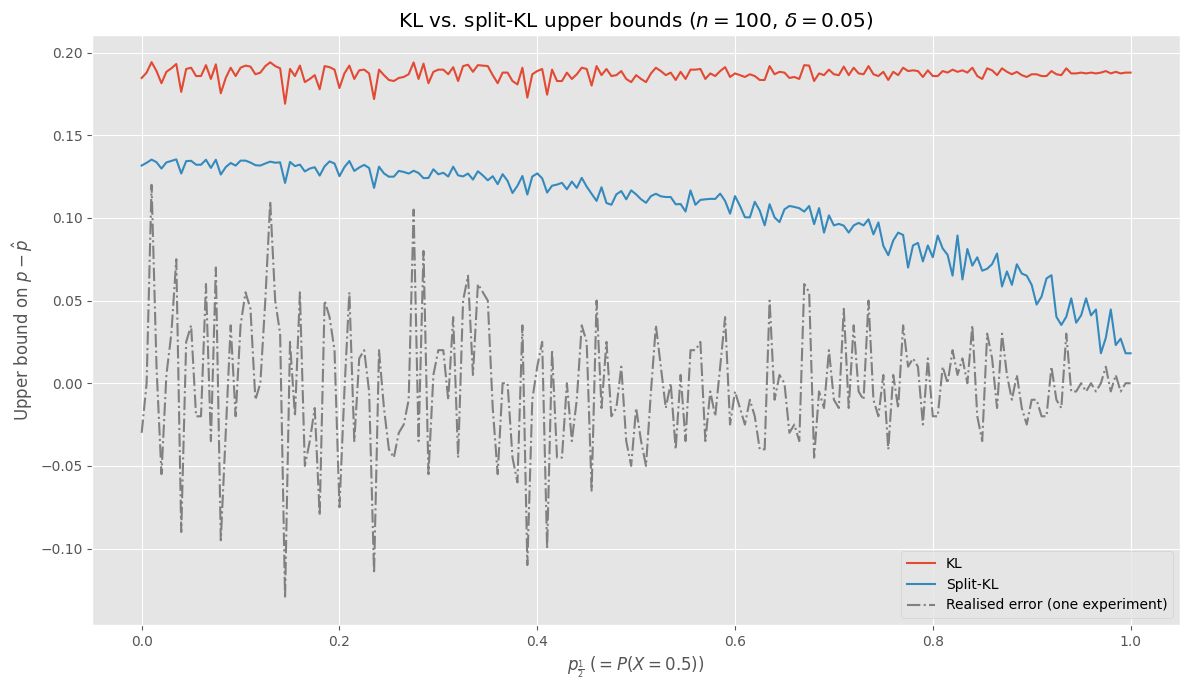

In [9]:
plt.figure(figsize=(12, 7))
plt.plot(p_12_grid, gap_kl, label="KL")
plt.plot(p_12_grid, gap_splitkl, label="Split-KL")
plt.plot(
    p_12_grid, real_error, "-.", color="grey", label="Realised error (one experiment)"
)

plt.xlabel(r"$p_{\frac{1}{2}} \;(=P(X=0.5))$")
plt.ylabel(r"Upper bound on $p - \hat p$")
plt.title(rf"KL vs. split-KL upper bounds ($n={n}$, $\delta={delta}$)")
plt.legend()
plt.tight_layout()

savefig = False
if savefig:
    plt.savefig("./figures/exercise_2_6_splitkl_vs_kl.png", dpi=600)
plt.show()